# Analyse des nationalités et leur évolution dans le temps 

Dans ce carnet est proposée une analyse de la place des nationalités sous forme de présences dans les aires géographiques en fonction du temps.


En tenant compte des effectifs, deux périodes (moderne et contemporaine) ont été distinguées. Pour l'époque contemporaine apparaît clairement l'augmentation de la présence des pays émergents, mais aussi des continuités, comme pour la Scandinavie, ou des présences différentes comme pour les Iles britanniques ou l'Europe méditerranéenne.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [2]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql

In [3]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

## Importer les données à analyser

In [4]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/astronomers_import.db')
cn

In [5]:
qr = """
SELECT wp.personUri, wp.personLabel, 
 CASE 
       WHEN wp.genderUri = 	'http://www.wikidata.org/entity/Q6581097'
       THEN 'M'
       WHEN wp.genderUri = 	'http://www.wikidata.org/entity/Q6581072'
       THEN 'F'
       ELSE 'A'
   END AS gender, max(wp.birthYear) AS birthYear,
   max(ga.label) AS area_label
FROM wdt_personne wp 
   JOIN wdt_person_citizenship wpc
	 ON wpc.personUri = wp.personUri
   JOIN wdt_country wc 
     ON wc.wdt_uri = wpc.nationaliteUri 
   JOIN geographic_area ga
     ON ga.pk_geographic_area = wc.fk_geographic_area
     GROUP BY wp.personUri, personLabel
"""

In [6]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()
print(len(l))
l[:3]

23459


[('http://www.wikidata.org/entity/Q1000193',
  'Hans Elsässer',
  'M',
  '1929',
  'Espace_germanique'),
 ('http://www.wikidata.org/entity/Q1000934',
  'Charles Christian Lauritsen',
  'M',
  '1892',
  'Amérique_nord'),
 ('http://www.wikidata.org/entity/Q100153910',
  'Frank J. Blatt',
  'M',
  '1924',
  'Espace_germanique')]

In [7]:
### Créer un DataFrame contenant les données
df_orig = pd.DataFrame(l, columns=['uri', 'nom', 'gender', 'annee_nais', 
                     'origines_geog'])
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23459 entries, 0 to 23458
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   uri            23459 non-null  object
 1   nom            23459 non-null  object
 2   gender         23459 non-null  object
 3   annee_nais     23459 non-null  object
 4   origines_geog  23459 non-null  object
dtypes: object(5)
memory usage: 916.5+ KB


In [8]:
### Distribution des aires géographiques d'origine
df_orig.groupby(by='origines_geog').size().sort_values(ascending=False)

origines_geog
Amérique_nord                4074
Espace_germanique            3966
Russie                       2522
Europe_centrale              2442
France_Benelux               2366
Europe_méridionale           1930
Iles_britanniques            1582
Scandinavie                  1326
Asie_orientale_Chine         1232
Asie_méridionale_Inde         661
Moyen_Orient_Afrique_Nord     482
Amérique_latine               474
Balkans                       345
Afrique_subsaharienne          57
dtype: int64

In [9]:
### Distribution des genres
df_orig.groupby(by='gender').size().sort_values(ascending=False)

gender
M    21392
F     2055
A       12
dtype: int64

### Codage par périodes de cinquante ans

In [10]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_orig['annee_nais'] = df_orig['annee_nais'].astype(int)

In [11]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_orig[df_orig['annee_nais'] < 1981].copy(deep=True)
cdf_p.head(3)

,uri,nom,gender,annee_nais,origines_geog
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,M,1929,Espace_germanique
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,M,1892,Amérique_nord
2,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,M,1924,Espace_germanique


In [12]:
### Année minimale et maximale dans la population
min(cdf_p['annee_nais']), max(cdf_p['annee_nais'])

(1360, 1980)

In [13]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_50 = list(range(1351, 2002, 50))
l_50[:5],l_50[-5:]

([1351, 1401, 1451, 1501, 1551], [1801, 1851, 1901, 1951, 2001])

In [14]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_nais'], l_50, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,uri,nom,gender,annee_nais,origines_geog,periodes
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,M,1929,Espace_germanique,1901-1950
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,M,1892,Amérique_nord,1851-1900
2,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,M,1924,Espace_germanique,1901-1950


In [39]:
### compter les naissances par périodes de 50 ans
cdf_p.groupby(by='periodes', observed=True).size()

periodes
1351-1400       13
1401-1450       30
1451-1500       66
1501-1550      100
1551-1600      149
1601-1650      158
1651-1700      208
1701-1750      420
1751-1800      523
1801-1850     1253
1851-1900     3123
1901-1950    11676
1951-2000     5005
dtype: int64

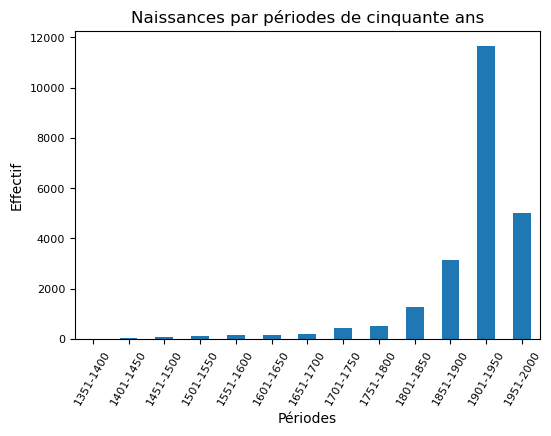

In [16]:
ax = cdf_p.groupby(by='periodes', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(6,4))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de cinquante ans')
plt.show()

### Distributions des origines géographiques par périodes

In [17]:
cdf_p[(cdf_p.annee_nais < 1801) ].groupby(by='origines_geog')\
    .size()

origines_geog
Amérique_latine                8
Amérique_nord                 34
Asie_méridionale_Inde          5
Asie_orientale_Chine          39
Balkans                        2
Espace_germanique            468
Europe_centrale               92
Europe_méridionale           155
France_Benelux               409
Iles_britanniques            266
Moyen_Orient_Afrique_Nord     19
Russie                        64
Scandinavie                  106
dtype: int64

In [18]:
cdf_p[(cdf_p.annee_nais > 1800) ].groupby(by='origines_geog')\
    .size()

origines_geog
Afrique_subsaharienne          52
Amérique_latine               440
Amérique_nord                3899
Asie_méridionale_Inde         639
Asie_orientale_Chine         1158
Balkans                       283
Espace_germanique            3417
Europe_centrale              2259
Europe_méridionale           1663
France_Benelux               1911
Iles_britanniques            1274
Moyen_Orient_Afrique_Nord     445
Russie                       2424
Scandinavie                  1193
dtype: int64

#### Création de deux tableaux de données pour périodes moderne et contemporaine

In [19]:
cdf_mod = cdf_p[(cdf_p.annee_nais < 1801)].copy(deep=True)
cdf_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1667 entries, 13 to 23455
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   uri            1667 non-null   object  
 1   nom            1667 non-null   object  
 2   gender         1667 non-null   object  
 3   annee_nais     1667 non-null   int64   
 4   origines_geog  1667 non-null   object  
 5   periodes       1667 non-null   category
dtypes: category(1), int64(1), object(4)
memory usage: 80.4+ KB


In [40]:
cdf_cont = cdf_p[(cdf_p.annee_nais > 1800)].copy(deep=True)
cdf_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21057 entries, 0 to 23458
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   uri            21057 non-null  object  
 1   nom            21057 non-null  object  
 2   gender         21057 non-null  object  
 3   annee_nais     21057 non-null  int64   
 4   origines_geog  21057 non-null  object  
 5   periodes       21057 non-null  category
dtypes: category(1), int64(1), object(4)
memory usage: 1008.3+ KB


## Epoque moderne: periode et aire géographique

In [21]:
### Tableau de contingence
X = "periodes"  # "0"
Y = "origines_geog"

ddf = cdf_mod[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

periodes,1351-1400,1401-1450,1451-1500,1501-1550,1551-1600,1601-1650,1651-1700,1701-1750,1751-1800,Total
origines_geog,,,,,,,,,,
Amérique_latine,0,0,0,0,1,0,2,2,3,8
Amérique_nord,0,0,0,0,0,0,2,11,21,34
Asie_méridionale_Inde,1,1,0,1,0,0,0,0,2,5
Asie_orientale_Chine,2,2,3,1,5,7,6,4,9,39
Balkans,0,1,0,0,0,0,0,1,0,2
Espace_germanique,3,6,35,46,50,40,61,94,133,468
Europe_centrale,3,8,8,4,7,8,7,31,16,92
Europe_méridionale,2,3,9,17,22,7,13,40,42,155
France_Benelux,1,5,4,18,36,49,62,113,121,409


#### Commentaire du tableau de contingence

On observe un fort déséquilibre entre les périodes et les aires géographiques. On peut le commenter, par exemple en relevant le développement des États Unis et de la Russie au 18e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants

Il serait probablement opportun de mélanger les niveaux aire géographiques et pays comme France, Pays-Bas, etc. pour améliorer l'analyse

In [22]:
### Production du tableau à analyser
D = ddf.iloc[5:10,2:-1].copy(deep=True)
D

periodes,1451-1500,1501-1550,1551-1600,1601-1650,1651-1700,1701-1750,1751-1800
origines_geog,,,,,,,
Espace_germanique,35,46,50,40,61,94,133
Europe_centrale,8,4,7,8,7,31,16
Europe_méridionale,9,17,22,7,13,40,42
France_Benelux,4,18,36,49,62,113,121
Iles_britanniques,2,7,15,32,34,72,104


In [23]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 5 , 7 ), effectif: 1359 , nombre max. facteurs: 4


In [24]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 102.73611721718783 , dof : 24
p-value : 1.0221260332124025e-11
phi2 = inertie (variance totale) : 0.07559684857776881
Cramer:  0.1598045484761636


### Commentaire

Noter la petite valeur de p value, on peut rejeter l'hypothèse d'indépendance. 

Le lien n'est pas très fort, mais on profite des axes factoriels pour prendre connaissance des tendances 

In [25]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['1451-1500', '1501-1550', '1551-1600', '1601-1650', '1651-1700',
       '1701-1750', '1751-1800'],
      dtype='object', name='periodes'),
   row_labels=Index(['Espace_germanique', 'Europe_centrale', 'Europe_méridionale',
       'France_Benelux', 'Iles_britanniques'],
      dtype='object', name='origines_geog'))

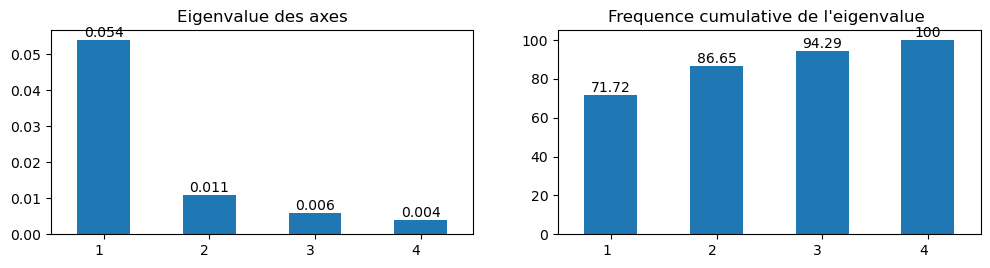

In [26]:
eig = pd.DataFrame(afc.eig_)

r1 = round(eig.iloc[0], 3)
r2 = round(eig.iloc[2], 2)
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])


# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

NB: la valeur propre des axes (eigenvalue) est la valeur de la variance exprimée par ce axe. Il s'agit donc d'une portion du phi-2, i.e. du chi-2 divisé par le nombre d'individus de la population. 100% de la variance équivaut au phi-2.
<br/>

### Graphiques et interprétation du premier plan factoriel

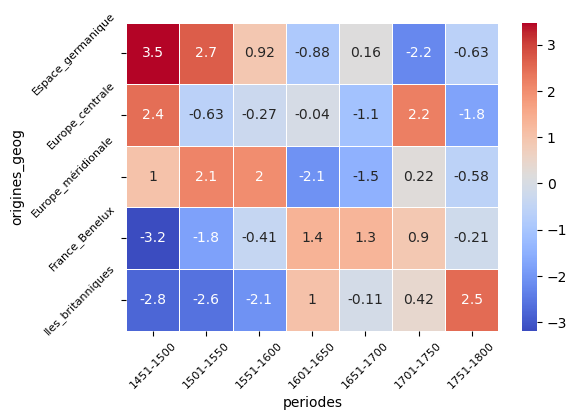

In [27]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=45, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=45, fontsize=8)

plt.savefig('images/mod_periode_aire_resid_ponderes.jpg', bbox_inches='tight')
plt.show()


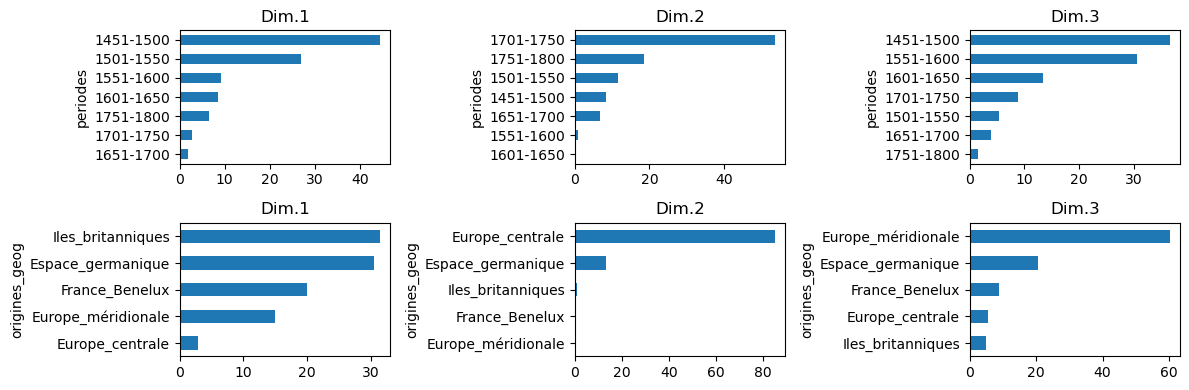

In [28]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


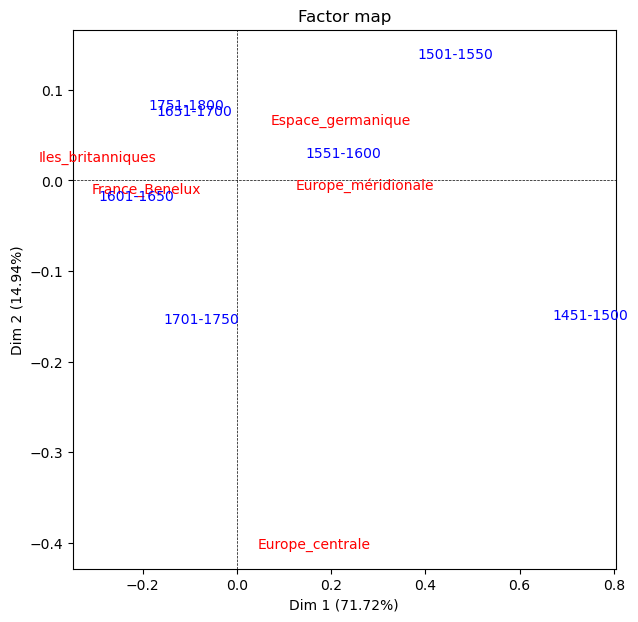

In [29]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

### Représenter l'autre plan factoriel

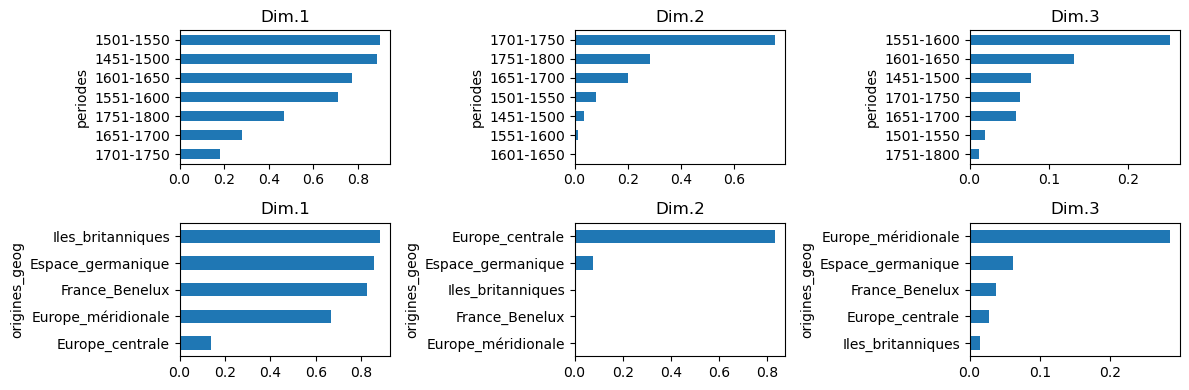

In [30]:
### Informations sur les cosinus carrés. Ces valeurs expriment 
# la qualité de représentation d'une modalité sur l'axe correspondant

### Colonnes
df = afc.col_topandas()[['col_cos2_dim1',
                         'col_cos2_dim2',
                         'col_cos2_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Lignes
df = afc.row_topandas()[['row_cos2_dim1',
                         'row_cos2_dim2',
                         'row_cos2_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


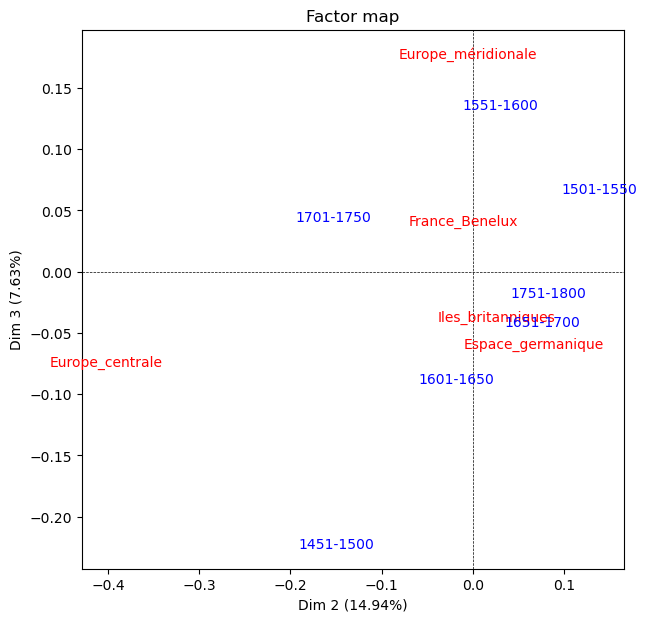

In [31]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))

In [32]:
D

periodes,1451-1500,1501-1550,1551-1600,1601-1650,1651-1700,1701-1750,1751-1800
origines_geog,,,,,,,
Espace_germanique,35,46,50,40,61,94,133
Europe_centrale,8,4,7,8,7,31,16
Europe_méridionale,9,17,22,7,13,40,42
France_Benelux,4,18,36,49,62,113,121
Iles_britanniques,2,7,15,32,34,72,104


## Epoque contemporaine: periode et aire géographique

In [50]:
### Tableau de contingence
X = "periodes"  # "0"
Y = "origines_geog"

ddf = cdf_cont[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

periodes,1801-1850,1851-1900,1901-1950,1951-2000,Total
origines_geog,,,,,
Afrique_subsaharienne,1,10,30,11,52
Amérique_latine,8,34,255,143,440
Amérique_nord,139,500,2490,770,3899
Asie_méridionale_Inde,11,61,390,177,639
Asie_orientale_Chine,8,80,741,329,1158
Balkans,2,7,134,140,283
Espace_germanique,312,762,1634,709,3417
Europe_centrale,49,261,1315,634,2259
Europe_méridionale,131,235,648,649,1663


#### Commentaire du tableau de contingence

On observe une entrée tardive de l'Afrique subsaharienne, qui risque de biaiser les données. Elle ne sera donc pas comprise dans l'analyse.


Aussi, les effectifs des Balkans et Moyen_Orient_Afrique_Nord sont faibles et risquent d'apporter des biais, car il vont être très visibles. On les gardes provisoirement, on décidéra après analyse.


Après une première analyse, on décide de les enlever pour mettre en évidence les tendances des grandes aires. Les aires moins représentées pourraient être soumis à analyses spécifiques en utilisant les pays. 

In [34]:
### Production du tableau à analyser
D = ddf.iloc[1:-1,:-1].copy(deep=True)
D

periodes,1801-1850,1851-1900,1901-1950,1951-2000
origines_geog,,,,
Amérique_latine,8,34,255,143
Amérique_nord,139,500,2490,770
Asie_méridionale_Inde,11,61,390,177
Asie_orientale_Chine,8,80,741,329
Balkans,2,7,134,140
Espace_germanique,312,762,1634,709
Europe_centrale,49,261,1315,634
Europe_méridionale,131,235,648,649
France_Benelux,217,408,840,446


In [35]:
ddf.index.to_list()

['Afrique_subsaharienne',
 'Amérique_latine',
 'Amérique_nord',
 'Asie_méridionale_Inde',
 'Asie_orientale_Chine',
 'Balkans',
 'Espace_germanique',
 'Europe_centrale',
 'Europe_méridionale',
 'France_Benelux',
 'Iles_britanniques',
 'Moyen_Orient_Afrique_Nord',
 'Russie',
 'Scandinavie',
 'Total']

In [58]:
li = ['Amérique_latine', 'Amérique_nord',
       'Asie_méridionale_Inde', 'Asie_orientale_Chine',
       'Espace_germanique', 'Europe_centrale', 'Europe_méridionale',
       'France_Benelux', 'Iles_britanniques',
       'Russie', 'Scandinavie']

In [37]:
lc = ['1801-1850', '1851-1900', '1901-1950', '1951-2000']

In [60]:
ddf.loc[li,lc]

periodes,1801-1850,1851-1900,1901-1950,1951-2000
origines_geog,,,,
Amérique_latine,8,34,255,143
Amérique_nord,139,500,2490,770
Asie_méridionale_Inde,11,61,390,177
Asie_orientale_Chine,8,80,741,329
Espace_germanique,312,762,1634,709
Europe_centrale,49,261,1315,634
Europe_méridionale,131,235,648,649
France_Benelux,217,408,840,446
Iles_britanniques,190,236,648,200


In [62]:
### Production du tableau à analyser
D = ddf.loc[ll,lc].copy(deep=True)
D

periodes,1801-1850,1851-1900,1901-1950,1951-2000
origines_geog,,,,
Amérique_latine,8,34,255,143
Amérique_nord,139,500,2490,770
Asie_méridionale_Inde,11,61,390,177
Asie_orientale_Chine,8,80,741,329
Espace_germanique,312,762,1634,709
Europe_centrale,49,261,1315,634
Europe_méridionale,131,235,648,649
France_Benelux,217,408,840,446
Iles_britanniques,190,236,648,200


In [63]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 11 , 4 ), effectif: 20277 , nombre max. facteurs: 3


In [66]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 1545.0591441905447 , dof : 30
p-value : 9.84022478336198e-307
phi2 = inertie (variance totale) : 0.07619762017017037
Cramer:  0.18405803379765892


### Commentaire

Noter la petite valeur de p value, on peut rejeter l'hypothèse d'indépendance. 

Le lien n'est pas très fort, mais on profite des axes factoriels pour prendre connaissance des tendances 

In [67]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['1801-1850', '1851-1900', '1901-1950', '1951-2000'], dtype='object', name='periodes'),
   row_labels=Index(['Amérique_latine', 'Amérique_nord', 'Asie_méridionale_Inde',
       'Asie_orientale_Chine', 'Espace_germanique', 'Europe_centrale',
       'Europe_méridionale', 'France_Benelux', 'Iles_britanniques', 'Russie',
       'Scandinavie'],
      dtype='object', name='origines_geog'))

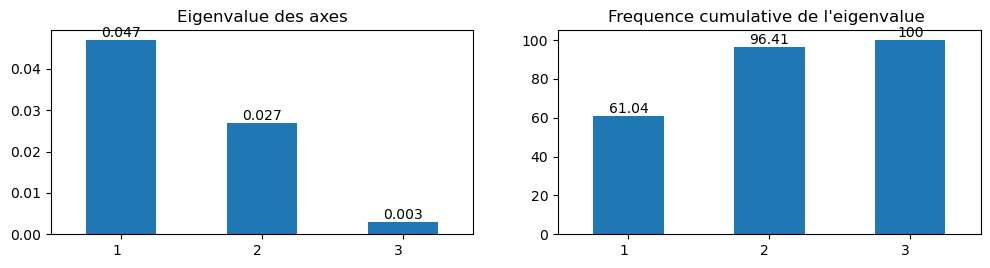

In [68]:
eig = pd.DataFrame(afc.eig_)

r1 = round(eig.iloc[0], 3)
r2 = round(eig.iloc[2], 2)
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])


# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

NB: la valeur propre des axes (eigenvalue) est la valeur de la variance exprimée par ce axe. Il s'agit donc d'une portion du phi-2, i.e. du chi-2 divisé par le nombre d'individus de la population. 100% de la variance équivaut au phi-2.
<br/>

### Graphiques et interprétation du premier plan factoriel

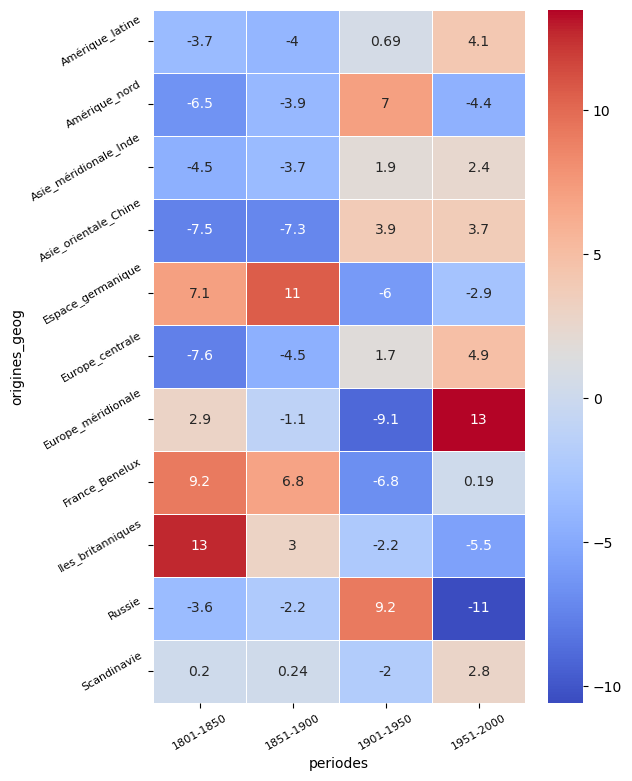

In [69]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,9))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=30, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=30, fontsize=8)

plt.savefig('images/cont_periode_aire_resid_ponderes.jpg', bbox_inches='tight')
plt.show()


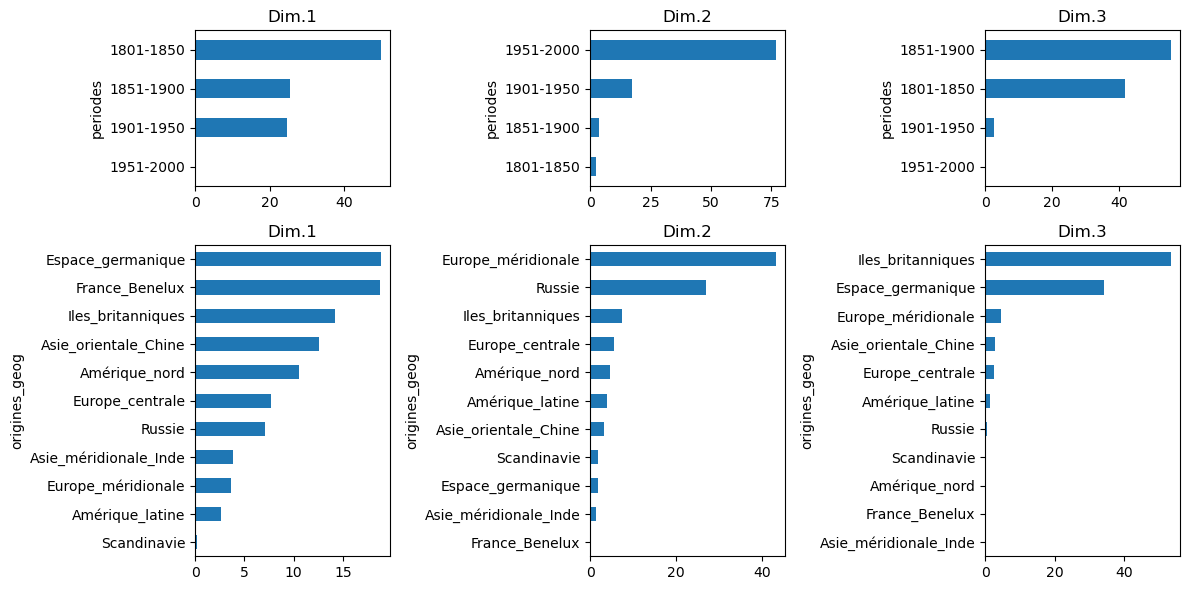

In [70]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6),
                          gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


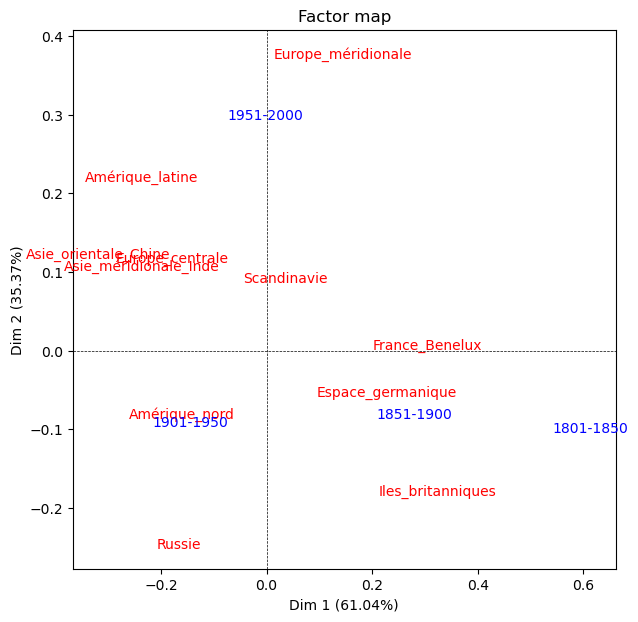

In [71]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

### Représenter l'autre plan factoriel

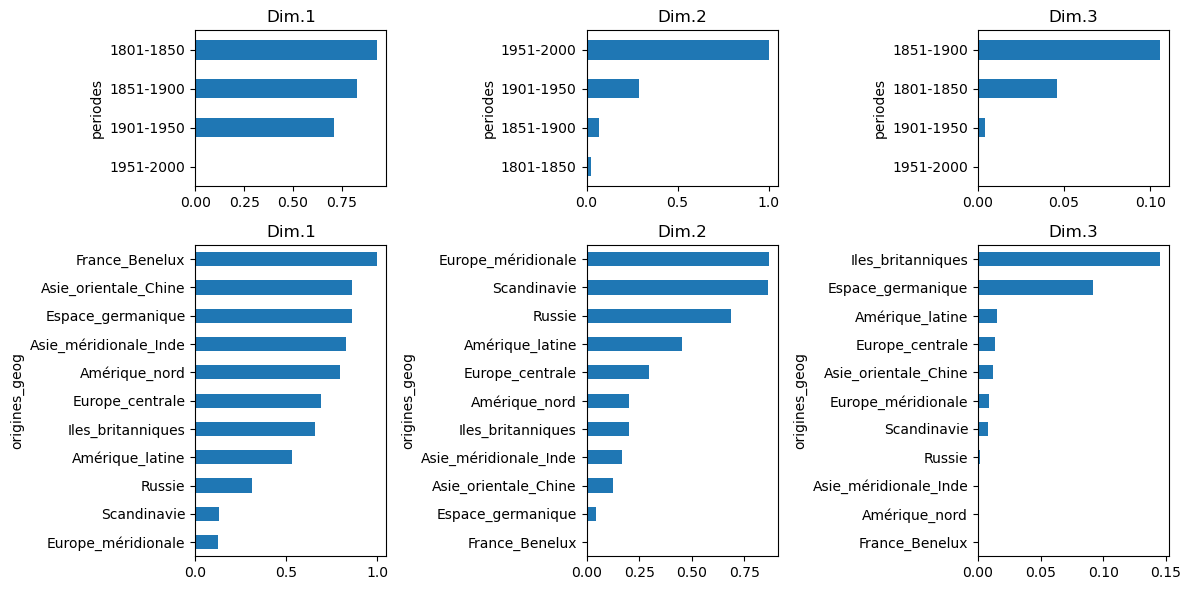

In [72]:
### Informations sur les cosinus carrés. Ces valeurs expriment 
# la qualité de représentation d'une modalité sur l'axe correspondant

### Colonnes
df = afc.col_topandas()[['col_cos2_dim1',
                         'col_cos2_dim2',
                         'col_cos2_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), 
                         gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Lignes
df = afc.row_topandas()[['row_cos2_dim1',
                         'row_cos2_dim2',
                         'row_cos2_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


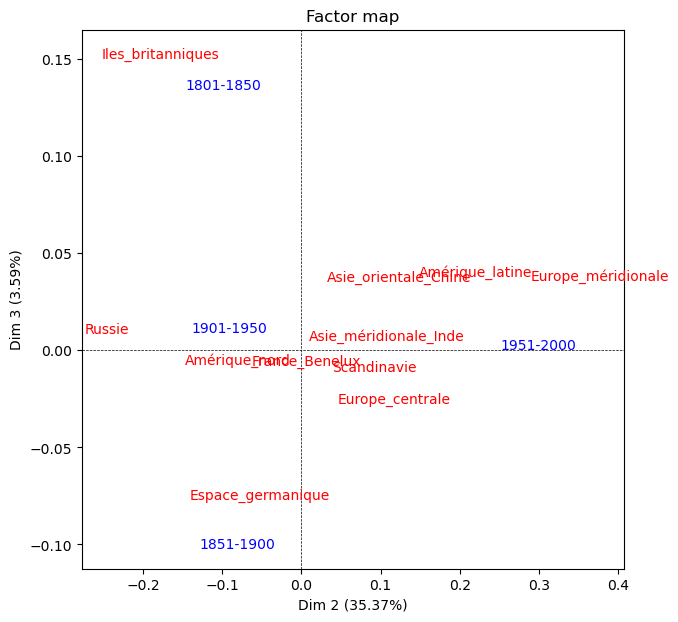

In [73]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))

In [74]:
D

periodes,1801-1850,1851-1900,1901-1950,1951-2000
origines_geog,,,,
Amérique_latine,8,34,255,143
Amérique_nord,139,500,2490,770
Asie_méridionale_Inde,11,61,390,177
Asie_orientale_Chine,8,80,741,329
Espace_germanique,312,762,1634,709
Europe_centrale,49,261,1315,634
Europe_méridionale,131,235,648,649
France_Benelux,217,408,840,446
Iles_britanniques,190,236,648,200
